In [9]:
## Standard imports
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import torch
import astroddpm
import tqdm.notebook as tqdm
import copy

## Relative imports
from astroddpm.runners import Diffuser, config_from_id, get_samples
from astroddpm.analysis.validationMetrics import powerSpectrum, minkowskiFunctional, basics
from astroddpm.analysis import overfitting_check
from astroddpm.utils.plot import check_nearest_epoch, plot_losses, check_training_samples, plot_comparaison
from astroddpm.diffusion.dm import DiscreteSBM, ContinuousSBM
from astroddpm.diffusion.stochastic.sde import DiscreteVPSDE, ContinuousVPSDE
from astroddpm.diffusion.stochastic.solver import EulerMaruyama
from astroddpm.diffusion.models.network import ResUNet
import astroddpm.diffusion.power_spectra.powerspec_sampler as powerspecsampler
import astroddpm.utils.colormap_custom 

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
CKPT_DIR = "/mnt/home/dheurtel/ceph/02_checkpoints"
SAMPLE_DIR = "/mnt/home/dheurtel/ceph/03_samples"

amin, amax = -3, 6

In [12]:
MODEL_ID = 'SBM_MultiSigmaVPSDE_I_BPROJ_test'

In [13]:
cont_sde = ContinuousVPSDE()
cont_unet = ResUNet(in_c = 1,out_c = 1,first_c=10,sizes = [256,128,64,32,16], discretization='continuous',has_phi = True, skiprescale=True, phi_shape=2, phi_embed_dim=100)

In [14]:
ps = powerspecsampler.CMB_H_OMBH2()

In [15]:
cont_diffmodel = ContinuousSBM(cont_sde, cont_unet, ps=ps).to(device)

In [16]:
#cont_diffmodel.config

In [17]:
base_config = {
        "diffusion_model": {
            "sde": {
                "type": "DiscreteVPSDE",
                "beta_min": 0.1,
                "beta_max": 20.0,
                "N": 4000
            },
            "network": {
                "in_c": 1,
                "out_c": 1,
                "first_c": 10,
                "sizes": [
                    256,
                    128,
                    64,
                    32,
                    16
                ],
                "num_blocks": 1,
                "n_steps": 4000,
                "time_emb_dim": 100,
                "dropout": 0,
                "attention": [],
                "normalisation": "GN",
                "padding_mode": "circular",
                "eps_norm": 1e-05,
                "skiprescale": True,
                "type": "ResUNet",
                "discretization": "discrete",
                "embedding_mode": None
            },
            "type": "DiscreteSBM",
            "ps": {
                "type": "constant",
                "ps_path": "/mnt/home/dheurtel/astroddpm/astroddpm/diffusion/power_spectra/power_spectra/cmb_256_8arcmippixel.npy"
            }
        },
        "dataloaders": {
            "train_batch_size": 64,
            "test_batch_size": 128,
            "num_workers": 8,
            "seed": 33,
            "split": 0.1,
            "dataset": {
                "dir": "/mnt/home/dheurtel/ceph/01_data/CATS_I/",
                "type": "npy files",
                "transforms": [
                    "Random_Rotate90"
                ],
                "name": "CATS_I"
            },
            "name": "CATS_I"
        },
        "optimizer": {
            "type": "AdamW",
            "lr": 0.001,
            "weight_decay": 0.0001
        },
        "scheduler": {
            "type": "invsqrt",
            "warmup": 100,
            "maxlr": 0.0004,
            "minlr": 4e-05,
            "last_step": -1
        },
        "ckpt_epoch": 200,
        "separate_ckpt": False,
        "ckpt_dir": "/mnt/home/dheurtel/ceph/02_checkpoints",
        "sample_epoch": 200,
        "sample_dir": "/mnt/home/dheurtel/ceph/03_samples",
        "sample_size": 8,
        "results_size": 64,
        "epochs": 15000,
        "model_id": "DiscreteSBM_SigmaVPSDE_I_BPROJ_N_4000_bottleneck_16_firstc_10"
    }

In [18]:
new_config = copy.deepcopy(base_config)

new_config['diffusion_model'] = cont_diffmodel.config
new_config['model_id'] = MODEL_ID
new_config['ckpt_dir'] = CKPT_DIR
new_config['sample_dir'] = SAMPLE_DIR
new_config['epochs'] = 150
new_config['ckpt_epoch'] = 50
new_config['sample_epoch'] = 50

In [20]:
diffuser = Diffuser(cont_diffmodel)
diffuser.load(config=new_config, also_ckpt=True)

No model id found
Loading the diffuser from a config dict.
Loading only the weights, no optimizer or scheduler.


In [21]:
diffuser.model_id

'SBM_MultiSigmaVPSDE_I_BPROJ_test'

In [13]:
losses = diffuser.train()

Epochs provided as attribute, using it. Be warned the model will start training at self.epoch until self.epochs-1.
Successfully saved checkpoint to /mnt/home/dheurtel/ceph/02_checkpoints/SBM_MultiSigmaVPSDE_I_BPROJ_test


  0%|          | 0/150 [00:00<?, ?it/s]

Successfully saved checkpoint to /mnt/home/dheurtel/ceph/02_checkpoints/SBM_MultiSigmaVPSDE_I_BPROJ_test


 33%|███▎      | 50/150 [02:57<05:32,  3.33s/it]

Successfully saved checkpoint to /mnt/home/dheurtel/ceph/02_checkpoints/SBM_MultiSigmaVPSDE_I_BPROJ_test


 67%|██████▋   | 100/150 [05:52<02:46,  3.32s/it]

Successfully saved checkpoint to /mnt/home/dheurtel/ceph/02_checkpoints/SBM_MultiSigmaVPSDE_I_BPROJ_test


 99%|█████████▉| 149/150 [08:44<00:03,  3.26s/it]

Training finished. Final sampling and checkpointing.


100%|██████████| 150/150 [09:38<00:00,  3.85s/it]

Successfully saved checkpoint to /mnt/home/dheurtel/ceph/02_checkpoints/SBM_MultiSigmaVPSDE_I_BPROJ_test


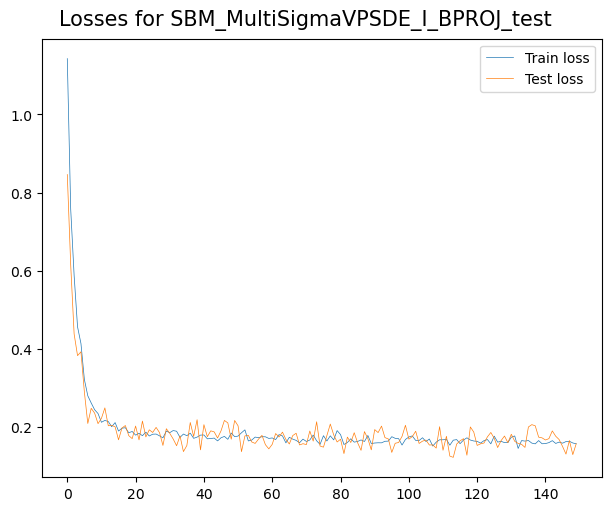

In [14]:
plot_losses(diffuser, figsize=(6, 5))

In [22]:
samples = diffuser.diffmodel.generate_image(8)

In [23]:
import astroddpm.diffusion.stochastic as stochastic

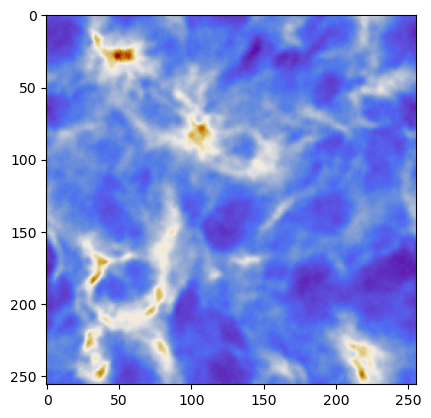

In [16]:
plt.imshow(samples[1,0].cpu(), cmap='cmb')